# Sequences Lab solutions

In [1]:
from datascience import *
import numpy as np
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import scipy.stats as stats
import scipy as scipy
import pandas as pd
plt.style.use('fivethirtyeight')
#from client.api.notebook import Notebook

## Reference Assembly

In [2]:
# Let's imagine we've performed an experiment and obtained the set of 8 reads below. We happen to know 
# that these correspond to the coding sequence of a gene of length 45 nucleotides.

reads = ['ATGCTAGAAA','GGAGACTGCT','AGTTAGTCAT','CCATAGCTGA',
 'AGAAACGGCT','CGGCTAGTTA','CTGCTCCATA','GTCATGGAGA']

In [3]:
# We want to use these reads to obtain the actual sequence of the entire gene. Let's assume that each read overlaps
# with only one other by exactly 5 bp. These overlaps will be in the first and last 5 nt of each read.
# By stitching these reads together, we can thus obtain the entire gene.

# Assemble the reads to yield the sequence of the gene. Call this value full_seq

# Extract them from the raw sequences and populate the lists.
prefixes = [i[0:5] for i in reads]
suffixes = [i[5:10] for i in reads]

# Initialize a matrix of zeros in which to store which reads overlap
match_mat = np.zeros((len(prefixes), len(suffixes)))

# Iterate over prefixes and suffixes to identify when the prefix of read i equals the suffix of read j
for i in np.arange(0,len(prefixes)):
    for j in np.arange(0,len(suffixes)):
        match_mat[i,j] = (prefixes[i] == suffixes[j])
        
print(match_mat)

ind = int(np.argwhere(np.sum(match_mat, axis = 1) == 0))  # find the read whose prefix doesn't match any suffixes
full_seq = reads[ind]                                     # initialize the full sequence with that read
# Iterate over the number of remaining sequences, identifying which read's prefix matches the current suffix
for i in np.arange(0,7):
    ind = int(np.argwhere(match_mat[:,ind] == 1))
    full_seq += suffixes[ind]
    
full_seq


[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


'ATGCTAGAAACGGCTAGTTAGTCATGGAGACTGCTCCATAGCTGA'

## Read mapping

In [4]:
# Now let's assume already have the reference sequences for two different genes and want to quantify
# their expression levels. We perform an experiment and get a set of reads, some of which come from these 
# genes. We can estimate their expression by counting the number of reads which match the sequence
# in the respective references. We only want to count reads which uniquely align to one gene or the other.

# Load the data

# Reference sequences
gene_1 = 'ATGCTAGAAACGGCTAGTTATTCATGGAGACTGCTCCATAGCTGA'
gene_2 = 'ATGTATGATCTCCAGGTATTCACGCAGTGCTCGCCTTACTTATAG'

# Reads from experiment
experimental_reads = [
 'TCATG','CGGCT','TGGAG','GCTCC','ACTGC','TTATT','TATTC','AGAAA','AACGG','AGCTG','CTAGT','GCTCC','ATGGA',
 'AACGG','TAGAA','ACGGC','ATAGC','GGAGA','TAGTT','CGGCT','ACTGC','GGCTA','GCTAG','GCTAG','AGTTA','TGCTA',
 'TTATT','TGCTA','GCTAG','AGAAA','AACGG','ATAGC','TTATT','TCCAG','TACTT','TGATC','CTTAT','TGATC','TTATA',
 'TCGCC','CTCCA','TGATC','CAGTG','TTATA','GCAGT','AGGTA','GCAGT','TGTAT','GCCTT','ATTCA','ATGAT','CTCCA',
 'CCTTA','GATCT','CAGGT','TCCAG','ACTTA','AATAT','ATGAA','TGTGG','GGTGC','GCAAG','CTACC','CACCG','TGGGG',
 'TAGGT','CTGCC','AGGCT','GGTAG','GGCGT','AGTGA','AATGT','CGTCG','CGTCC','GTACC','AGGGA','ATCGG','CTCTT',
 'CCGGA','AATGG','CTTTC','TAAAT','TATAA','GGTTA','AAAGG','TCAGG','GCATT']


In [5]:
# Write a function that takes two sequences, one test and one reference, as input and 
# checks whether the test sequence aligns to the reference

def read_map_check(test_seq, ref_seq):
    map_flag = test_seq in ref_seq
    return(map_flag)

In [6]:
# Now apply your function to the set of experimental reads to produce the expression counts for each gene.
# Remember that only reads mapping uniquely to a given sequence will get counted.

# Initialize counters at zero
gene_1_hits = 0
gene_2_hits = 0

# For each experimental read, check whether it maps to a sequence in gene_1 or gene_2.
# If it maps uniquely to one gene, increase that gene's count by 1
for i in experimental_reads:          
    m1 = read_map_check(i, gene_1)    # does the read map to gene 1?
    m2 = read_map_check(i, gene_2)    # does the read map to gene 2?
    if m1 and not m2:                 # if unique to gene 1
        gene_1_hits += 1              # update gene 1 counts
    if m2 and not m1:                 # if unique to gene 2
        gene_2_hits += 1              # update gene 2 counts
        
gene_1_hits, gene_2_hits  

(32, 21)

## Comparing genetic sequences

In [7]:
# A simple way to compare the similarity of genetic sequences is to compute a quantity known as the Hamming distance.
# This measures the number of mismatches between pairs of sequences; e.g., d_H('ACG', 'ATG') = 1, 
# d_H('TAG', 'TAG') = 0, etc. 

# We will now compare the differences in the same gene observed in two "populations". First, load the provided data.

ref_pop_1 = 'ATGCTAGAAACGGCTAGTTAGTCATGGAGACTGCTCCATAGCTGA'
ref_pop_2 = 'ATGCAAGGAACGGCTAGTTATTCATGGAGACTGATCCATTGCTGA'

data_pop_1 = ['ATGCTAGAAAGGGCTAGTTAGACATGGAGACGGCTCCATAGCTGA', 'ATGCTAGTAACGGCTAGTTTGTCATGGAGACTGCTCCATACCTGA', 'ATGCTAGATACGGCTAGTTACTCATGGAGAGAGCTCCATAGCTGA', 'ATGCTAGTTACGGCTACTTAGTCATCGAGACTGCACCATAGCTGA', 'ATGCTAGAATCGGGTAGATAGTCATGGAGACAGCTCCATAGCTGA']
data_pop_2 = ['ATGCAAGCAACGGCTTGTTTTTCATGGACACTGATCCATTGCTGA', 'ATGCATGGAAGGGCTAGTTATTCTTGCAGACTGATCCATTGCTGA', 'ATGCAAGCAACGGCTAGTTATTCTTGGACACTGATGCATTGCTGA', 'ATGCAAGGAACGGCAAGTTAATCATGGTGACTCATCCATTGCTGA', 'ATGCAAGGAAGGGCTAGATATTCGTGGAGAGTGATCGATTGCTGA']


In [8]:
# Write a function which takes two sequences as input and outputs the Hamming distance between them.

def compute_hamming_dist(seq_1, seq_2):
    # check that they are the same length
    if len(seq_1) != len(seq_2):
        d = 'Error: sequences are not of same length'
    else:
        # initialize the distance to 0
        d = 0
        # count how many locations differ between the two
        for n in np.arange(0, len(seq_1)):
            d += (seq_1[n] != seq_2[n])
    return(d)

In [9]:
# Construct a matrix D in which D_{ij} = d_H(s_i, s_j) for sequences s_i and s_j.

# Combine the data from the different populations
merged_data = data_pop_1 + data_pop_2

# Initialize a distance matrix of all zeros
D = np.zeros((len(merged_data), len(merged_data)))

# Iterate over the sequences to find the Hamming distances between each pair
for i in np.arange(0, len(merged_data)):
    for j in np.arange(0, len(merged_data)):
        d_ij = compute_hamming_dist(merged_data[i], merged_data[j])
        D[i,j] = d_ij
    
D

array([[ 0.,  6.,  6.,  8.,  6., 11., 10., 11., 11., 11.],
       [ 6.,  0.,  7.,  6.,  7.,  8., 11., 10., 10., 12.],
       [ 6.,  7.,  0.,  7.,  6., 11., 12., 11., 11., 11.],
       [ 8.,  6.,  7.,  0.,  9., 12., 13., 12., 12., 14.],
       [ 6.,  7.,  6.,  9.,  0., 12., 13., 12., 12., 12.],
       [11.,  8., 11., 12., 12.,  0.,  8.,  4.,  8.,  9.],
       [10., 11., 12., 13., 13.,  8.,  0.,  6.,  8.,  6.],
       [11., 10., 11., 12., 12.,  4.,  6.,  0.,  8.,  8.],
       [11., 10., 11., 12., 12.,  8.,  8.,  8.,  0.,  9.],
       [11., 12., 11., 14., 12.,  9.,  6.,  8.,  9.,  0.]])

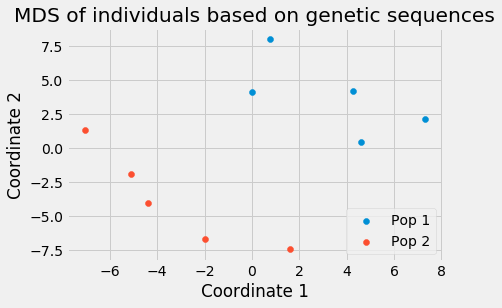

In [10]:
# Use MDS to examine whether the individuals cluster in any noticeable way

# You don't need to edit this part
from sklearn.manifold import MDS
mds = MDS(n_components=2, random_state = 100200300, dissimilarity="precomputed")
proj = mds.fit_transform(D)

# Now make a scatter plot of the MDS projection (proj) with the points colored by population
plt.scatter(proj[0:5, 0], proj[0:5, 1])     # plot the points corresponding to population 1
plt.scatter(proj[5:10, 0], proj[5:10, 1])   # plot the points corresponding to population 2
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.title('MDS of individuals based on genetic sequences')
plt.legend(['Pop 1', 'Pop 2'], loc = 'lower right')
plt.show()

## To submit

In [11]:
#ok = Notebook('Lab03_sequences.ok')
#_ = ok.auth(inline=True)

In [12]:
# Submit the assignment.
#_ = ok.submit()